In [1]:
from time import time
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

$$ 
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - u\frac{\partial C}{\partial x} + r
$$

In [149]:
def PFR(t, y, u, D, c_in, dx):
    """
    Differential equations for the PFR equations.

    The ODEs are derived using the method of lines.
    """
    # dydt is the return value of this function.
    dydt = np.zeros_like(y)

    # Compute dy/dt.  The end points and the interior points
    # are handled separately.
    dydt[0] = - u*(-c_in+y[0])/dx# + D*(-2.0*c_in + 2.0*y[1]) / dx**2
    #dydt[1:-1] = D*np.diff(y,2) / dx**2
    dydt[1:] -= u*np.diff(y)/dx
    #dydt[-1]   += 2.0*D*(- y[-1] + y[-2]) / dx**2# - u*(-y[-1]+y[-2])/dx
    
    return dydt

In [168]:
x = np.linspace(0,1, num=11)
y0 = np.zeros_like(x)
y0[0]=1
# y0 = np.random.randn(5000)
t = np.linspace(0, 100, 11)
u = 0.001
D = 0.0
c_in = 1
dx = 0.01

In [169]:
time0= time()
sol = solve_ivp(lambda t,y: PFR(t,y,u,D,c_in,dx), (0,100), y0, method='BDF')
print(time()-time0)

0.020001888275146484


In [170]:
from ipywidgets import interact, widgets
@interact
def f(t=(0, len(sol.t)-1)):
    y = sol.y[:,t]
    plt.plot(y)
    plt.title(f'time={sol.t[t]:.5f}')
    plt.ylim((-0.1,1.1))

interactive(children=(IntSlider(value=23, description='t', max=47), Output()), _dom_classes=('widget-interact'…

In [154]:
y = sol.y
y[:,:].shape
ar = np.arange(5)
ar2d = np.zeros(20)
ar2d.shape=(2,2,5)

In [71]:
np.diff(x)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

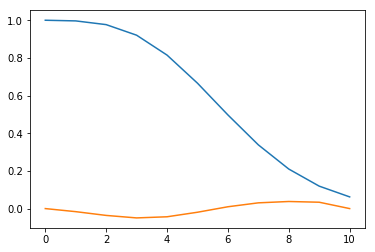

In [179]:
y = sol.y[:,40]
plt.plot(y)
plt.plot(np.concatenate(([0],np.diff(y, 2), [0])))

In [177]:
np.concatenate(([0],np.diff(y)))

array([ 0.        , -0.00348025, -0.01980417, -0.05609357, -0.10565079,
       -0.14917035, -0.16859239, -0.15889913, -0.1284105 , -0.09078644,
       -0.05702623])

In [17]:
plt.imshow(y, aspect='auto', cmap='Greys', origin='lower')
plt.colorbar()

NameError: name 'y' is not defined